### Plots for the QUBICC models

**For Figures 6 and 7**

Note that by scaling the data not until the single batches are predicted, we only need a fraction of memory (<50GB or so)! So far we have first scaled the data and then predicted the batches which sometimes exceeds 500GB.

In [1]:
import os
import gc
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add path with my_classes to sys.path
sys.path.insert(0, '/pf/b/b309170/workspace_icon-ml/cloud_cover_parameterization/')

# Add path with functions to sys.path
sys.path.insert(0, '/additional_content/plots_offline_paper/auxiliary')

import functions
from my_classes import load_data

from tensorflow.keras import backend as K

from tensorflow import nn 
from tensorflow.keras.models import load_model

import importlib
importlib.reload(functions)

ORDER_OF_VARS_NARVAL = ['qv', 'qc', 'qi', 'temp', 'pres', 'u', 'v', 'zg', 'coriolis', 'fr_land', 'clc', 'cl_area']
(TIME_STEPS, VERT_LAYERS, HORIZ_FIELDS) = (1721, 31, 4450) # For Narval data

path = '/pf/b/b309170/workspace_icon-ml/cloud_cover_parameterization'

In [25]:
import matplotlib

# Increase the general font size in plots
size_plots_label = 11
matplotlib.rcParams['legend.fontsize'] = size_plots_label
matplotlib.rcParams['axes.labelsize'] = size_plots_label # For an axes xlabel and ylabel
matplotlib.rcParams['axes.titlesize'] = size_plots_label+2 # For an axes xlabel and ylabel
matplotlib.rcParams['xtick.labelsize'] = size_plots_label
matplotlib.rcParams['ytick.labelsize'] = size_plots_label

# Averaged over the NARVAL region
zg_mean_narval = [20785,19153,17604,16134,14741,13422,12175,10998,9890,8848,
                  7871,6958,6107,5317,4587,3915,3300,2741,2237,1787,1390,1046,
                  754,515,329,199,128] # in meters

zg_mean_narval = np.round(np.array(zg_mean_narval)/1000, decimals=1) # in kilometers

# Averaged globally
zg_mean_qubicc = [20785,19153,17604,16134,14742,13424,12178,11002,9896,8857,
                  7885,6977,6133,5351,4630,3968,3363,2814,2320,1878,1490,1153,
                  867,634,452,324,254] # in meters
zg_mean_qubicc = np.round(np.array(zg_mean_qubicc)/1000, decimals=1) # in kilometers

green='#004D40'
red='#D81B60'
blue='#1E88E5'

### Scaling parameters
Taken from scalings.txt

In [3]:
# Cell-based model, fold 2
cell_mean = np.array([3.60451178e-03,1.06371446e-05,3.73792945e-06,2.54823043e+02,5.53563125e+04,4.80185201e+00,2.08690253e-02,6.35512546e+03,-3.51841227e-06,2.50654436e-01])
cell_var = np.array([2.10344167e-05,2.28944346e-09,3.60565660e-10,8.87054949e+02,9.45197543e+08,8.35647159e+01,2.49623994e+01,3.17266073e+07,6.90316790e-09,1.75488130e-01])
cell_std = np.sqrt(cell_var)

# Region-based model, fold 3
region_mean = np.array([3.41263902e-03,7.93922615e-06,2.78343441e-06,2.52995285e+02,5.33758389e+04,5.17777331e+00,2.10204309e-02,6.86232697e+03,-2.41056479e-06,3.81125084e-03,3.01124776e-03,8.27269855e-06,7.19535995e-06,2.77749692e-06,2.77568803e-06,2.56022193e+02,2.50084674e+02,5.69273612e+04,4.97714694e+04,4.95565841e+00,5.34952501e+00,2.86906099e-02,1.15836877e-02,6.11993878e+03,7.66764978e+03,2.87028199e+02])
region_var = np.array([2.13574258e-05,1.67161259e-09,2.73507802e-10,9.62399724e+02,1.01420507e+09,8.96530891e+01,2.49368518e+01,3.66381310e+07,7.01356187e-09,2.39161767e-05,1.85645216e-05,2.03227245e-09,1.21768482e-09,2.73145748e-10,2.73514345e-10,9.29101514e+02,9.73138057e+02,9.98213690e+08,1.01043633e+09,8.74345980e+01,9.26022343e+01,2.47190652e+01,2.50739444e+01,3.13968027e+07,4.24214017e+07,2.31351167e+02])
region_std = np.sqrt(region_var) # Need to divide by the standard deviation

# Region-based model with RH, fold 3
region_rh_mean = np.array([7.93922615e-06, 2.78343441e-06, 2.52995285e+02, 5.20950783e-01, 8.27269855e-06, 7.19535995e-06, 2.77749692e-06, 2.77568803e-06, 2.56022193e+02, 2.50084674e+02, 5.48467376e-01, 4.88794767e-01])
region_rh_std = np.array([4.08853591e-05, 1.65380713e-05, 3.10225680e+01, 3.06383471e-01, 4.50807326e-05, 3.48953410e-05, 1.65271216e-05, 1.65382691e-05, 3.04811666e+01, 3.11951608e+01, 2.99084028e-01, 3.12048872e-01]) # Need to divide by the standard deviation

# Column-based model, fold 2
column_mean = np.array([2.57681365e-06,2.60161901e-06,2.86229890e-06,3.49524686e-06,6.32444387e-06,1.62852938e-05,4.26197236e-05,1.00492283e-04,2.10850387e-04,3.96992495e-04,6.62768743e-04,1.00639902e-03,1.42273038e-03,1.89269379e-03,2.42406883e-03,2.97704256e-03,3.52303812e-03,4.15430913e-03,4.89285256e-03,5.71192194e-03,6.58451740e-03,7.47955824e-03,8.42949837e-03,9.18162558e-03,9.58900058e-03,9.80246788e-03,9.98071441e-03,1.99662055e-48,1.97795858e-36,2.80309683e-33,1.17327341e-31,1.33296743e-30,1.45585956e-29,2.57897497e-16,1.24502901e-08,5.43912468e-07,1.97554777e-06,2.10205332e-06,3.45718981e-06,4.17987790e-06,4.89876027e-06,6.03250921e-06,6.71487544e-06,7.71281746e-06,9.96528417e-06,1.40351017e-05,1.87534642e-05,2.15523809e-05,1.77725032e-05,1.10700238e-05,6.98113679e-06,5.98240074e-06,8.03857856e-06,1.55278994e-05,1.98903187e-13,1.45240003e-10,2.39426913e-08,5.63226688e-07,3.10209365e-06,6.64324795e-06,8.83422658e-06,9.89681102e-06,9.97096463e-06,7.74324652e-06,4.95774608e-06,2.61087000e-06,1.29680563e-06,7.46596833e-07,4.94444102e-07,3.51674311e-07,2.61199355e-07,2.03219747e-07,1.66907845e-07,1.42871199e-07,1.25114261e-07,1.11956533e-07,1.02782118e-07,9.86031894e-08,9.95790399e-08,1.06733810e-07,1.26921172e-07,2.10924633e+02,2.07944695e+02,2.05115507e+02,2.03204784e+02,2.06103772e+02,2.12329817e+02,2.19299382e+02,2.26348890e+02,2.33352039e+02,2.40105681e+02,2.46401637e+02,2.52153555e+02,2.57207037e+02,2.61575645e+02,2.65446543e+02,2.68951996e+02,2.72093136e+02,2.74765728e+02,2.76963041e+02,2.78775116e+02,2.80398659e+02,2.81959850e+02,2.83501227e+02,2.84935364e+02,2.86119192e+02,2.86867707e+02,2.87046277e+02,4.78805278e+03,6.25615004e+03,8.06726288e+03,1.03500805e+04,1.30603494e+04,1.61944127e+04,1.97232230e+04,2.36181577e+04,2.78401230e+04,3.23377105e+04,3.70511232e+04,4.19785078e+04,4.70365400e+04,5.21124420e+04,5.72512536e+04,6.23517142e+04,6.72989145e+04,7.20972394e+04,7.66740332e+04,8.09510300e+04,8.49437983e+04,8.85136468e+04,9.16490946e+04,9.42529147e+04,9.63348759e+04,9.77633315e+04,9.86144363e+04,2.07846270e+04,1.91533379e+04,1.76039570e+04,1.61343240e+04,1.47416307e+04,1.34230525e+04,1.21768751e+04,1.10012039e+04,9.89431495e+03,8.85470770e+03,7.88104473e+03,6.97198713e+03,6.12617252e+03,5.34218664e+03,4.61854836e+03,3.95376191e+03,3.34629894e+03,2.79465640e+03,2.29750295e+03,1.85381761e+03,1.46282067e+03,1.12390793e+03,8.36771545e+02,6.01482480e+02,4.18667943e+02,2.90324051e+02,2.20122534e+02,2.57179068e-01])
column_var = np.array([2.77480154e-14,7.25973243e-14,3.99634524e-13,2.15710125e-12,8.11907271e-12,7.61775265e-11,8.77316868e-10,6.92865621e-09,3.75024285e-08,1.46188082e-07,3.94244487e-07,8.66497643e-07,1.62353588e-06,2.62130562e-06,3.83192714e-06,4.99991907e-06,6.21865064e-06,8.01241132e-06,1.03693004e-05,1.31320424e-05,1.64074160e-05,2.06036189e-05,2.64319947e-05,3.14889456e-05,3.38882152e-05,3.50739205e-05,3.62542223e-05,0.00000000e+00,0.00000000e+00,0.00000000e+00,0.00000000e+00,0.00000000e+00,0.00000000e+00,3.75468927e-24,3.77859683e-14,8.81399575e-12,7.67332158e-11,1.05524206e-10,2.10047036e-10,2.74443979e-10,3.28792625e-10,4.40183561e-10,5.82035529e-10,7.95968863e-10,1.27540590e-09,2.26932659e-09,3.55040982e-09,4.36412766e-09,3.36921887e-09,1.94898287e-09,1.31932279e-09,1.47840427e-09,3.00631977e-09,1.02475319e-08,8.08985898e-20,7.53000365e-15,6.63133983e-12,7.29001841e-11,3.89494832e-10,7.85358520e-10,9.33067822e-10,1.00578451e-09,1.04125431e-09,7.02788016e-10,3.35540989e-10,1.10604147e-10,3.62540093e-11,2.00711744e-11,1.03744494e-11,4.94660958e-12,2.65516680e-12,1.73694133e-12,1.30232159e-12,1.05309331e-12,8.92800996e-13,7.95007256e-13,7.34063569e-13,6.97679020e-13,6.71116696e-13,6.55904608e-13,7.00761126e-13,2.13386790e+01,2.83620543e+01,4.35373333e+01,6.58895818e+01,4.11327685e+01,1.25161844e+01,1.04050676e+01,3.03990896e+01,5.92444799e+01,8.44920290e+01,1.01262923e+02,1.09040431e+02,1.10571059e+02,1.10489555e+02,1.11241419e+02,1.15661026e+02,1.22910740e+02,1.29881594e+02,1.37074237e+02,1.45675391e+02,1.56059349e+02,1.66116415e+02,1.76086646e+02,1.87903449e+02,2.02713567e+02,2.17913355e+02,2.36656922e+02,2.74458895e+04,5.11391869e+04,1.04446470e+05,2.32219429e+05,4.84596804e+05,8.52038001e+05,1.28343711e+06,1.71290868e+06,2.08304820e+06,2.37089800e+06,2.59898548e+06,2.83694575e+06,3.17998519e+06,3.73075481e+06,4.63958852e+06,6.01537006e+06,7.86646627e+06,1.02806323e+07,1.32050071e+07,1.65713281e+07,2.04336800e+07,2.44266133e+07,2.84576052e+07,3.20684854e+07,3.51439430e+07,3.73393052e+07,3.88460516e+07,0.00000000e+00,0.00000000e+00,0.00000000e+00,2.78852050e+00,2.02838259e+01,5.57561156e+01,1.42624190e+02,3.40661029e+02,7.63342522e+02,1.66784615e+03,3.61855509e+03,7.50449371e+03,1.44226070e+04,2.53310370e+04,4.07648391e+04,6.09571406e+04,8.56022800e+04,1.13726811e+05,1.44066944e+05,1.75744678e+05,2.07956727e+05,2.39436769e+05,2.68796829e+05,2.94535011e+05,3.15079095e+05,3.29944182e+05,3.36064654e+05,1.78957540e-01])
remove_fields = [27, 28, 29, 30, 31, 32, 135, 136, 137]
# Need to delete certain features for the column-based model    
column_mean = np.delete(column_mean, remove_fields)
column_var = np.delete(column_var, remove_fields)
column_std = np.sqrt(column_var) # Need to divide by the standard deviation

### Computations

#### **Cloud Cover** - Mean and R2, **QUBICC** data

Best cell-based model: **Fold 2**

In [ ]:
model_type = 'grid_cell_based_QUBICC_R02B05'

data_means, pred_means, r2_profile = functions.get_R2_and_means(model_type=model_type, 
                                                      model='cross_validation_cell_based_fold_2.h5', 
                                                      model_mean=cell_mean, model_std=cell_std, 
                                                      data_source='qubicc')

In [49]:
functions.write_to_file(model_type_short='Cell-based', data_source_capitalized='QUBICC', 
              data_means=data_means, pred_means=pred_means, r2_profile=r2_profile)

Best region-based model: **Fold 3**

In [73]:
model_type = 'region_based_one_nn_R02B05'

data_means, pred_means, r2_profile = functions.get_R2_and_means(model_type=model_type, 
                                                      model='cross_validation_region_based_fold_3.h5', 
                                                      model_mean=region_mean, model_std=region_std,
                                                      data_source='qubicc')

KeyboardInterrupt: 

In [32]:
functions.write_to_file(model_type_short='Region-based', data_source_capitalized='QUBICC', 
              data_means=data_means, pred_means=pred_means, r2_profile=r2_profile)

Best column-based model: **Fold 2**

In [ ]:
model_type = 'grid_column_based_QUBICC_R02B05'

data_means, pred_means, r2_profile = functions.get_R2_and_means(model_type=model_type, 
                                                      model='cross_validation_column_based_fold_2.h5', 
                                                      model_mean=column_mean, model_std=column_std,
                                                      data_source='qubicc')

In [ ]:
functions.write_to_file(model_type_short='Column-based', data_source_capitalized='QUBICC', 
              data_means=data_means, pred_means=pred_means, r2_profile=r2_profile)

--------------------------------------------------

#### **Cloud Cover** - Mean and R2, **NARVAL** data

In [3]:
# # First we have to load the NARVAL data (if not already done so)
# try:
#     narval_data
# except:    
#     narval_data = load_data(source='narval', days='all', vert_interp=True, resolution='R02B05', 
#                         order_of_vars=ORDER_OF_VARS_NARVAL)
    
    
# First we have to load the NARVAL data (if not already done so)
narval_data = load_data(source='narval', days='all', vert_interp=True, resolution='R02B05', 
                    order_of_vars=ORDER_OF_VARS_NARVAL)

qv
qc
qi
temp
pres
u
v


Best cell-based model: **Fold 2**

In [54]:
model_type = 'grid_cell_based_QUBICC_R02B05'

# Be careful to pass a copy of narval_data
data_means, pred_means, r2_profile = functions.get_R2_and_means(model_type=model_type, 
                                                      model='cross_validation_cell_based_fold_2.h5', 
                                                      model_mean=cell_mean, model_std=cell_std, 
                                                      data_source='narval', 
                                                      narval_data=narval_data.copy())

In [55]:
functions.write_to_file(model_type_short='Cell-based', data_source_capitalized='NARVAL', 
              data_means=data_means, pred_means=pred_means, r2_profile=r2_profile)

Best region-based model: **Fold 3**

In [78]:
model_type = 'region_based_one_nn_R02B05'

data_means, pred_means, r2_profile = functions.get_R2_and_means(model_type=model_type, 
                                                      model='cross_validation_region_based_fold_3.h5', 
                                                      model_mean=region_mean, model_std=region_std,
                                                      data_source='narval', 
                                                      narval_data=narval_data.copy())

Index(['qv', 'qc', 'qi', 'temp', 'pres', 'u', 'v', 'zg', 'coriolis',
       'qv_below', 'qv_above', 'qc_below', 'qc_above', 'qi_below', 'qi_above',
       'temp_below', 'temp_above', 'pres_below', 'pres_above', 'u_below',
       'u_above', 'v_below', 'v_above', 'zg_below', 'zg_above', 'temp_sfc',
       'clc'],
      dtype='object')


In [79]:
functions.write_to_file(model_type_short='Region-based', data_source_capitalized='NARVAL', 
              data_means=data_means, pred_means=pred_means, r2_profile=r2_profile)

Best column-based model: **Fold 2**

In [70]:
model_type = 'grid_column_based_QUBICC_R02B05'

data_means, pred_means, r2_profile = functions.get_R2_and_means(model_type=model_type, 
                                                      model='cross_validation_column_based_fold_2.h5', 
                                                      model_mean=column_mean, model_std=column_std,
                                                      data_source='narval', 
                                                      narval_data=narval_data.copy())

In [71]:
functions.write_to_file(model_type_short='Column-based', data_source_capitalized='NARVAL', 
              data_means=data_means, pred_means=pred_means, r2_profile=r2_profile)

--------------------------------------------------

#### **Cloud Area** - Mean and R2, **QUBICC** data

Best cell-based model: **Fold 2**

In [6]:
model_type = 'grid_cell_based_QUBICC_R02B05'

data_means, pred_means, r2_profile = functions.get_R2_and_means(model_type=model_type, 
                                                      model='cross_validation_cell_based_fold_2.h5', 
                                                      model_mean=cell_mean, model_std=cell_std, 
                                                      data_source='qubicc', output_type='cloud_area')

In [7]:
functions.write_to_file(model_type_short='Cell-based', data_source_capitalized='QUBICC', 
              data_means=data_means, pred_means=pred_means, r2_profile=r2_profile, 
              output_type='cloud_area')

Best region-based model: **Fold 3**

In [8]:
model_type = 'region_based_one_nn_R02B05'

data_means, pred_means, r2_profile = functions.get_R2_and_means(model_type=model_type, 
                                                      model='cross_validation_region_based_fold_3.h5', 
                                                      model_mean=region_mean, model_std=region_std,
                                                      data_source='qubicc', output_type='cloud_area')

In [9]:
functions.write_to_file(model_type_short='Region-based', data_source_capitalized='QUBICC', 
              data_means=data_means, pred_means=pred_means, r2_profile=r2_profile,
              output_type='cloud_area')

Best column-based model: **Fold 2**

In [10]:
model_type = 'grid_column_based_QUBICC_R02B05'

data_means, pred_means, r2_profile = functions.get_R2_and_means(model_type=model_type, 
                                                      model='cross_validation_column_based_fold_2.h5', 
                                                      model_mean=column_mean, model_std=column_std,
                                                      data_source='qubicc', output_type='cloud_area')

In [11]:
functions.write_to_file(model_type_short='Column-based', data_source_capitalized='QUBICC', 
              data_means=data_means, pred_means=pred_means, r2_profile=r2_profile, 
              output_type='cloud_area')

--------------------------------------------------

#### **Cloud** Area - Mean and R2, **NARVAL** data

In [82]:
narval_data = load_data(source='narval', days='all', vert_interp=True, resolution='R02B05', 
                    order_of_vars=ORDER_OF_VARS_NARVAL)

qv
qc
qi
temp
pres
u
v


In [80]:
# First we have to load the NARVAL data (if not already done so)
try:
    narval_data
except:    
    narval_data = load_data(source='narval', days='all', vert_interp=True, resolution='R02B05', 
                        order_of_vars=ORDER_OF_VARS_NARVAL)

Best cell-based model: **Fold 2**

In [83]:
model_type = 'grid_cell_based_QUBICC_R02B05'

data_means, pred_means, r2_profile = functions.get_R2_and_means(model_type=model_type, 
                                                      model='cross_validation_cell_based_fold_2.h5', 
                                                      model_mean=cell_mean, model_std=cell_std, 
                                                      data_source='narval', output_type='cloud_area',
                                                      narval_data=narval_data.copy())

Index(['qv', 'qc', 'qi', 'temp', 'pres', 'u', 'v', 'zg', 'coriolis', 'fr_land',
       'cl_area'],
      dtype='object')


In [84]:
functions.write_to_file(model_type_short='Cell-based', data_source_capitalized='NARVAL', 
              data_means=data_means, pred_means=pred_means, r2_profile=r2_profile, 
              output_type='cloud_area')

Best region-based model: **Fold 3**

In [85]:
model_type = 'region_based_one_nn_R02B05'

data_means, pred_means, r2_profile = functions.get_R2_and_means(model_type=model_type, 
                                                      model='cross_validation_region_based_fold_3.h5', 
                                                      model_mean=region_mean, model_std=region_std,
                                                      data_source='narval', output_type='cloud_area',
                                                      narval_data=narval_data.copy())

Index(['qv', 'qc', 'qi', 'temp', 'pres', 'u', 'v', 'zg', 'coriolis',
       'qv_below', 'qv_above', 'qc_below', 'qc_above', 'qi_below', 'qi_above',
       'temp_below', 'temp_above', 'pres_below', 'pres_above', 'u_below',
       'u_above', 'v_below', 'v_above', 'zg_below', 'zg_above', 'temp_sfc',
       'cl_area'],
      dtype='object')


In [86]:
functions.write_to_file(model_type_short='Region-based', data_source_capitalized='NARVAL', 
              data_means=data_means, pred_means=pred_means, r2_profile=r2_profile,
              output_type='cloud_area')

Best column-based model: **Fold 2**

In [87]:
model_type = 'grid_column_based_QUBICC_R02B05'

data_means, pred_means, r2_profile = functions.get_R2_and_means(model_type=model_type, 
                                                      model='cross_validation_column_based_fold_2.h5', 
                                                      model_mean=column_mean, model_std=column_std,
                                                      data_source='narval', output_type='cloud_area',
                                                      narval_data=narval_data.copy())

In [88]:
functions.write_to_file(model_type_short='Column-based', data_source_capitalized='NARVAL', 
              data_means=data_means, pred_means=pred_means, r2_profile=r2_profile, 
              output_type='cloud_area')

### Plotting

Actually only the column-based model has been evaluated against the entirety of the QUBICC data

Extracted the values from **auxiliary/qubicc_models_r2_and_mean_values.txt**

In [4]:
data_mean_column_clc_qubicc = [1.22387715e-06,1.75380915e-04,1.84490351e-02,9.94078871e-01,6.60239813e+00,1.29995848e+01,1.51688517e+01,1.54871999e+01,1.62403147e+01,1.73318351e+01,1.64966325e+01,1.37455571e+01,1.11041396e+01,9.32026106e+00,8.36775526e+00,7.63329073e+00,7.44714336e+00,7.77969862e+00,8.80163593e+00,1.03660682e+01,1.19648834e+01,1.17286423e+01,9.22991797e+00,6.75212303e+00,5.58614523e+00,5.47661340e+00,6.33819903e+00]
np.mean(data_mean_column_clc_qubicc)

8.999318354107116

In [5]:
a = np.arange(21, 48)

In [6]:
# Cell-based model, cloud cover, QUBICC data
data_mean_cell_clc_qubicc = [3.841538345145142e-06, 0.0005453614672033295, 0.05691244149242802, 2.3449602020967064, 12.444598724787479, 22.11177398393874, 24.347654474362976, 23.90246947407832, 24.768993143209446, 26.56257177501748, 25.63668123335315, 22.17313132547816, 18.111320872421096, 15.648018492455478, 13.966145552251836, 13.043058057524984, 12.529846804436975, 12.530078040641364, 13.224430334080576, 14.349438763926976, 15.895538055468002, 14.65326234194765, 12.409737968731122, 10.973593315415568, 10.774425279647877, 11.60190561057367, 13.876887404065195]
pred_mean_cell_clc_qubicc = [0.4411079136434669, 0.15049791994744832, 0.047936059009951494, 1.817498935540729, 11.439025085210783, 20.859055198389648, 24.016521443027, 23.798379341000178, 25.15464142814349, 26.82754396666599, 25.40990308622784, 21.792651130337187, 17.737596946241354, 15.102907046266246, 13.683767522458336, 12.866069213500058, 12.32441064459703, 12.324597136132383, 12.9812123832571, 14.038710984065942, 15.387270472857539, 13.938705610743522, 11.673711723795497, 10.341883812038374, 10.182914176760212, 11.114175885341886, 14.220607913370833]
r2_profile_cell_clc_qubicc = [-100078.90391387127, -13.524611945461634, 0.6752899397427082, 0.7576698466013273, 0.8432081255313361, 0.9397691527721507, 0.9565517947262931, 0.9555749146708005, 0.9551302374588442, 0.9565930094873788, 0.9482193004731475, 0.9477769453781136, 0.953818648968911, 0.9552117829858398, 0.9567862423593427, 0.9603865272905906, 0.9617330622561243, 0.9619888295938416, 0.963147885843556, 0.9655259051736603, 0.9688935482147525, 0.9719748742219436, 0.9714855580335083, 0.968175336921593, 0.9640291398073322, 0.9610431269809113, 0.9552571418272219]

# Region-based model, cloud cover, QUBICC data
data_mean_region_clc_qubicc = [1.9208876923240345e-06, 0.00027276660052823366, 0.028738207167114657, 1.4311306970544682, 8.792021808104774, 16.63428496510756, 18.96011629438407, 19.044891933632787, 19.870799709463235, 21.25202843395766, 20.350094648836297, 17.22644474552825, 13.982837813058831, 11.88388593818427, 10.657135617836342, 9.831234522331785, 9.544810720120202, 9.811787787687026, 10.795414996371536, 12.26414252628997, 13.883925604245334, 13.200284460058693, 10.779748493194308, 8.565515533466062, 7.545801040852391, 7.635116725767375, 8.916681590972978]
pred_mean_region_clc_qubicc = [0.5011549718461098, 0.3505563133747664, 0.2569084928902815, 1.913930625812419, 10.066345582259267, 18.130216908197937, 20.540901549401408, 19.55175605058712, 20.504567053869387, 22.157119395892884, 21.021463407552428, 17.79631876864738, 14.593436351408998, 12.38133475750844, 10.929669090435093, 10.18853614835741, 9.881397194770004, 10.107572643226687, 11.058636731062741, 12.51401905130828, 14.055854117088215, 13.40891258596279, 11.077169349133307, 8.902362821736842, 7.79572095286461, 7.867010390664514, 9.513061801435942]
r2_profile_region_clc_qubicc = [-183913.32741259146, -73.9549710249245, 0.6251919416315432, 0.8197332958505396, 0.8799345446210222, 0.9072038413558182, 0.9375579996209785, 0.9581576558830536, 0.9660509025670136, 0.970883930656059, 0.9687499305253082, 0.9669354407890679, 0.9678862634975295, 0.9686374034262695, 0.969383970722046, 0.9724143547889316, 0.9729564254936415, 0.9728592410243232, 0.973492529506842, 0.9754009917172369, 0.9783898134260283, 0.9799264163700718, 0.9784619804269995, 0.9745792947444653, 0.9686862768610812, 0.960372277127074, 0.9511957326032859]

# Column-based model, cloud cover, QUBICC data
data_mean_column_clc_qubicc = [1.22387715e-06,1.75380915e-04,1.84490351e-02,9.94078871e-01,6.60239813e+00,1.29995848e+01,1.51688517e+01,1.54871999e+01,1.62403147e+01,1.73318351e+01,1.64966325e+01,1.37455571e+01,1.11041396e+01,9.32026106e+00,8.36775526e+00,7.63329073e+00,7.44714336e+00,7.77969862e+00,8.80163593e+00,1.03660682e+01,1.19648834e+01,1.17286423e+01,9.22991797e+00,6.75212303e+00,5.58614523e+00,5.47661340e+00,6.33819903e+00]
pred_mean_column_clc_qubicc = [1.58625454e-03,3.18158892e-03,5.45043151e-02,9.41533552e-01,6.39186491e+00,1.28809682e+01,1.51755462e+01,1.51935336e+01,1.59635877e+01,1.67467357e+01,1.66748379e+01,1.38854091e+01,1.10443748e+01,9.43020009e+00,8.67979540e+00,7.74791310e+00,7.37011555e+00,7.81993436e+00,9.10038338e+00,1.06177881e+01,1.24413002e+01,1.20222469e+01,9.63951819e+00,7.07380860e+00,5.74388950e+00,5.67710323e+00,6.46367120e+00]
r2_profile_column_clc_qubicc = [-17.46910878,-0.10673656,0.87651738,0.93855252,0.97067273,0.98251403,0.98576729,0.98465016,0.98448494,0.98509419,0.98457978,0.98335528,0.9811991,0.97966037,0.97877795,0.97940086,0.97943501,0.97893755,0.97902493,0.9805787,0.98230377,0.98341733,0.98188425,0.98094891,0.98057026,0.97974633,0.97943642]

print('Cell-based: ' + str(np.mean(r2_profile_cell_clc_qubicc[2:], dtype=np.float64)))
print('Region-based: ' + str(np.mean(r2_profile_region_clc_qubicc[2:], dtype=np.float64)))
print('Column-based: ' + str(np.mean(r2_profile_column_clc_qubicc[2:], dtype=np.float64)))

Cell-based: 0.9350096350928492
Region-based: 0.9426016982094491
Column-based: 0.9752604015999999


In [7]:
# Cell-based model, cloud cover, NARVAL data
data_mean_cell_clc_narval = [2.1550986461680797e-07, 0.0003179909437663545, 0.20494434534944103, 1.7601325251891469, 4.624023183041591, 7.634752593004967, 7.877963393492734, 6.026238005391097, 4.042293056280528, 2.946792568479466, 2.101387672821594, 1.7675782392293635, 2.1766590964216017, 2.8161592789700483, 2.47919885427541, 1.8782150760406413, 2.1351389201590676, 2.9440564917508074, 4.2554113749291895, 6.605344153967043, 10.241251275624322, 13.48884868006931, 11.83712906244796, 5.067683309062877, 0.9863144777183074, 0.2948893494619048, 0.1406815435005333]
pred_mean_cell_clc_narval = [0.2449211459733946, 0.00013574721196503637, 0.009718899166221567, 0.37610786539676017, 2.3054413608335125, 5.84618023545514, 8.37447979064143, 7.281785091916455, 5.38285932612583, 4.336699453118192, 3.4925633772051383, 2.803797826363567, 2.7202754598399546, 2.879515863358844, 2.585164564491188, 2.1496025563630634, 2.4569063137632168, 3.280098386371187, 4.5938336716446395, 6.9244930901822626, 10.158843741478602, 12.086781890594237, 8.309397042784925, 2.2564149607767403, 0.5156186582115533, 0.20528878497705683, 0.15826865341481103]
r2_profile_cell_clc_narval = [-5774807.293969403, -0.5215349419270396, 0.06674575584358478, 0.27614919331286214, 0.6044934408271723, 0.8362611323702012, 0.8982351328777926, 0.877317962868196, 0.8540966723468596, 0.7665555594426541, 0.519498947220373, 0.39593560594297716, 0.5325198399062909, 0.739779365232166, 0.873419671470917, 0.9109225896762647, 0.913667146964698, 0.917629943280511, 0.9216305840646611, 0.9188045393244968, 0.9136628687907907, 0.895042151197147, 0.7880406043166268, 0.6704930038392922, 0.7835959147941609, 0.8201245876363943, 0.7294118369540306]

# Region-based model, cloud cover, NARVAL data
data_mean_region_clc_narval = [2.1550986461680797e-07, 0.0003179909437663545, 0.20494434534944103, 1.7601325251891469, 4.624023183041591, 7.634752593004967, 7.877963393492734, 6.026238005391097, 4.042293056280528, 2.946792568479466, 2.101387672821594, 1.7675782392293635, 2.1766590964216017, 2.8161592789700483, 2.47919885427541, 1.8782150760406413, 2.1351389201590676, 2.9440564917508074, 4.2554113749291895, 6.605344153967043, 10.241251275624322, 13.48884868006931, 11.83712906244796, 5.067683309062877, 0.9863144777183074, 0.2948893494619048, 0.1406815435005333]
pred_mean_region_clc_narval = [0.23925119923543167, 0.005794218177283111, 0.1836357674766399, 1.5428370378032508, 4.694972069949019, 7.460736843910554, 9.616316522778543, 8.192544195609031, 6.228826388289143, 5.181585581225296, 4.178958736008718, 3.2162273800825028, 2.978176139159627, 3.2464555824382693, 2.731325574402838, 2.219070366896414, 2.474872409774308, 3.2851987681444177, 4.537164514585447, 6.796634688151023, 10.220364547175826, 12.806312999199095, 9.189646764339868, 3.003213708073862, 0.7803897146733502, 0.3016678454132854, 0.1439188216576221]
r2_profile_region_clc_narval = [-5277423.884728637, -3.431948409000669, 0.3859890129953234, 0.6563811945599467, 0.764867985433761, 0.7903952192081536, 0.8627969108573437, 0.8866085027040452, 0.8545358707479951, 0.7499583529878956, 0.546084739269155, 0.4895354959394955, 0.6443677792008267, 0.8011782006570982, 0.8963636593605532, 0.9264116764891521, 0.9255300127045519, 0.9181949991629268, 0.9175542566917184, 0.9171797751591438, 0.9126865089255136, 0.8917323652837684, 0.8312152255568986, 0.7646535642616239, 0.8353081415413136, 0.7984513219845147, 0.7275745989023938]

# Column-based model, cloud cover, NARVAL data
data_mean_column_clc_narval = [2.15509865e-07,3.17990944e-04,2.04944345e-01,1.76013253e+00,4.62402318e+00,7.63475259e+00,7.87796339e+00,6.02623801e+00,4.04229306e+00,2.94679257e+00,2.10138767e+00,1.76757824e+00,2.17665910e+00,2.81615928e+00,2.47919885e+00,1.87821508e+00,2.13513892e+00,2.94405649e+00,4.25541137e+00,6.60534415e+00,1.02412513e+01,1.34888487e+01,1.18371291e+01,5.06768331e+00,9.86314478e-01,2.94889349e-01,1.40681544e-01]
pred_mean_column_clc_narval = [3.76515660e-04,7.07414830e-04,3.98836229e-02,4.21516755e-01,3.43474821e+00,7.96200252e+00,8.99812154e+00,7.85514709e+00,5.45778245e+00,4.47946698e+00,3.84001976e+00,2.72198117e+00,2.71901161e+00,3.24943126e+00,2.89764465e+00,2.04203064e+00,2.38625041e+00,3.23492318e+00,4.97363482e+00,7.37885434e+00,1.19776192e+01,1.52024608e+01,9.82896119e+00,3.36159662e+00,1.06963439e+00,5.03276248e-01,3.10429488e-01]
r2_profile_column_clc_narval = [-1.26756770e+02,-7.20110101e-02,4.40132802e-02,3.75659356e-01,8.26186925e-01,9.00346422e-01,9.03150290e-01,8.61353703e-01,8.60270235e-01,7.50240454e-01,4.46532844e-01,5.05691513e-01,6.36633226e-01,7.67401070e-01,8.26769302e-01,8.49723832e-01,8.64693634e-01,8.86750898e-01,8.77026762e-01,8.83034420e-01,8.52631712e-01,8.08421971e-01,7.97430145e-01,7.69597776e-01,7.75053913e-01,7.71282897e-01,7.59129855e-01]

print('Cell-based: ' + str(np.mean(r2_profile_cell_clc_narval[2:], dtype=np.float64)))
print('Region-based: ' + str(np.mean(r2_profile_region_clc_narval[2:], dtype=np.float64)))
print('Column-based: ' + str(np.mean(r2_profile_column_clc_narval[2:], dtype=np.float64)))

Cell-based: 0.7369613620200449
Region-based: 0.7878222148234044
Column-based: 0.7439610574080001


In [8]:
pred_mean_column_clc_narval[32-21]

2.72198117

In [9]:
# Cell-based model, cloud area, QUBICC data
data_mean_cell_cl_area_qubicc = [1.9580698134053184e-05, 0.002836935456466214, 0.17421031160763673, 7.758789692128248, 22.7357533923229, 32.568869686378605, 35.6876685255663, 36.14211798243095, 36.533257227348585, 36.98876341166796, 34.90908167652795, 29.440612081477266, 26.917513820883297, 23.01467495562886, 22.944760462486887, 20.410538725561796, 20.207270877598265, 20.985545164874274, 22.85747830613221, 25.509278499944767, 24.798325440037086, 25.339603627182004, 19.188078047005913, 16.833124944293363, 15.463971988325136, 13.734183722227263, 12.573183634553157]
pred_mean_cell_cl_area_qubicc = [0.00878773714570994, 0.004884314127768241, 0.1105090639881172, 6.438019462743408, 23.152327203423255, 34.25371280757073, 36.53145924906455, 36.30369769745034, 36.39156738721911, 37.269038125493694, 34.87952116320355, 30.093120457095306, 25.953489265941393, 23.3765606992016, 21.59152237304908, 20.147577645613588, 19.61185476650476, 20.298958223512567, 22.419838330816585, 24.498591644593507, 24.92029283298435, 23.290703676206252, 19.039294927147658, 15.835984521037178, 14.19078504445779, 13.092151695043643, 14.07320676245259]
r2_profile_cell_cl_area_qubicc = [-198.5734125878699, 0.34157149154630295, 0.6011790462375672, 0.7615970087520582, 0.8574218858937301, 0.9102646615089572, 0.9362466235498255, 0.9287335960810132, 0.9275134897951272, 0.92671515943211, 0.9212758984434917, 0.9206857901578609, 0.9204839388885496, 0.9259690678311504, 0.91184957528616, 0.925798827704132, 0.9272044815996321, 0.9215234233371832, 0.9170125853324611, 0.9101172611289852, 0.9259717265518786, 0.9176667347264945, 0.9345628892150155, 0.9346170306581693, 0.9210860446012193, 0.9076876112339018, 0.8739971112271775]

# Region-based model, cloud area, QUBICC data
data_mean_region_cl_area_qubicc = [9.790953173836892e-06, 0.0014189144024907702, 0.08799943389980137, 4.735194281281057, 16.062650477499275, 24.500967671584256, 27.79086410673541, 28.797151498161394, 29.308637136083714, 29.59376265791435, 27.710451026063364, 22.872888657807398, 20.78181672790885, 17.47890423324241, 17.508877170672818, 15.385264934803974, 15.394033403329852, 16.434011485656857, 18.66035714139402, 21.803763783005127, 21.662998278214605, 22.828995752017153, 16.671396506307705, 13.144107430759854, 10.835589512979965, 9.045599628932692, 8.08136177242446]
pred_mean_region_cl_area_qubicc = [1.2191223288403126, 1.1950322049266389, 0.40098932888686634, 5.562700699723208, 16.687625247945498, 24.626130853148993, 26.619981104011885, 27.26984009108519, 28.555010759257513, 28.862624580735392, 26.66551521351787, 22.844271770938025, 19.461271934118127, 17.232124654459177, 16.08465109276798, 15.071290443570124, 14.887337083930921, 15.754544145885633, 17.713571497041066, 20.332421159309686, 22.167407316704903, 21.229505715775648, 17.753688231700036, 13.998309861286307, 11.412167289546373, 10.747745599607846, 10.986535560329168]
r2_profile_region_cl_area_qubicc = [-92361.61657023935, -29.269774876918493, 0.6541205621356879, 0.7774874652768883, 0.895769533631362, 0.9280203835264201, 0.9386499429418849, 0.9432366322976754, 0.9518394446889853, 0.9574323701488956, 0.95667793864563, 0.9573379438419782, 0.9508450898923818, 0.9525290353739718, 0.943835646028653, 0.9551816048499271, 0.9555798606954591, 0.9535790008944025, 0.9537279364520467, 0.9526674573189153, 0.9575174109080792, 0.953876425823797, 0.957750324974397, 0.9565087812287271, 0.9475503507556492, 0.9153320046700668, 0.873926466213448]

# Column-based model, cloud area, QUBICC data
data_mean_column_cl_area_qubicc = [6.59313698e-06,9.08781143e-04,5.64858302e-02,3.28880003e+00,1.20626222e+01,1.91472200e+01,2.22338520e+01,2.34143720e+01,2.39411735e+01,2.41225847e+01,2.24521875e+01,1.82433887e+01,1.64960935e+01,1.37043189e+01,1.37458225e+01,1.19474347e+01,1.20165960e+01,1.30423352e+01,1.52339221e+01,1.84487908e+01,1.86783578e+01,2.02848534e+01,1.42779580e+01,1.03678419e+01,8.02979617e+00,6.50216735e+00,5.74529021e+00]
pred_mean_column_cl_area_qubicc = [7.77625447e-03,1.96301934e-03,9.01025899e-02,3.23834545e+00,1.18152414e+01,1.90340178e+01,2.24503709e+01,2.33220907e+01,2.36628478e+01,2.35056387e+01,2.23242563e+01,1.85240645e+01,1.63857186e+01,1.38192013e+01,1.36131394e+01,1.20910168e+01,1.17525229e+01,1.30279949e+01,1.58311784e+01,1.88416778e+01,1.91470566e+01,2.03221078e+01,1.47943124e+01,1.07307221e+01,8.61235962e+00,6.80832377e+00,5.84374606e+00]
r2_profile_column_cl_area_qubicc = [-3.95101469e+01,1.13827528e-03,8.93460877e-01,9.32713826e-01,9.66348092e-01,9.77762476e-01,9.77996534e-01,9.76158434e-01,9.75015462e-01,9.75076140e-01,9.75388514e-01,9.74635688e-01,9.72043225e-01,9.69793196e-01,9.66250099e-01,9.68294961e-01,9.69331332e-01,9.69157843e-01,9.68868132e-01,9.71248188e-01,9.72805464e-01,9.73008352e-01,9.72036920e-01,9.70546828e-01,9.67402885e-01,9.63053712e-01,9.56767774e-01]

print('Cell-based: ' + str(np.mean(r2_profile_cell_cl_area_qubicc[2:], dtype=np.float64)))
print('Region-based: ' + str(np.mean(r2_profile_region_cl_area_qubicc[2:], dtype=np.float64)))
print('Column-based: ' + str(np.mean(r2_profile_column_cl_area_qubicc[2:], dtype=np.float64)))

Cell-based: 0.8986872587669539
Region-based: 0.9256391845286132
Column-based: 0.96620659816


In [51]:
# Cell-based model, cloud area, NARVAL data
data_mean_cell_cl_area_narval = [1.629578032284744e-06, 0.0015026554635810393, 0.5288372774887656, 3.9818536079009093, 9.760813278015311, 13.35221876894265, 12.933643550732029, 10.01167942348101, 6.8360792059427355, 4.418739933587359, 3.755689918359295, 2.733857316025685, 4.175782080407703, 5.540050921811345, 4.131512067008385, 3.8054674767139804, 3.5401489653475395, 5.58725188416795, 6.842163692723084, 12.512908468360315, 16.605054285817126, 20.85729156908585, 20.95974245556041, 8.8198802141689, 1.8380822224257172, 0.4066361717123824, 0.13561856694052318]
pred_mean_cell_cl_area_narval = [0.00027102002336744043, 0.0014267681311030613, 0.35151742604097796, 2.0739335547571365, 5.787589625274085, 10.601502325536922, 13.241797967271363, 11.663197140910121, 8.41670435885383, 6.442933336343708, 5.145400534868419, 4.22104830716174, 4.594291868532111, 5.3977070265395515, 4.311261334610428, 3.1390089175434484, 3.446314459710134, 4.70033614768321, 6.846771327652642, 10.888744820335582, 16.376974257173483, 20.53018047261921, 14.522784775071589, 4.427456376092848, 1.1713901457023124, 0.6213523729268292, 0.48167037771138665]
r2_profile_cell_cl_area_narval = [-40.05349109123952, -0.05904631163052554, 0.4009951877344319, 0.659917214783269, 0.7201595557237486, 0.8247702609659133, 0.8557795301171307, 0.8367094008199851, 0.8239476676024371, 0.7369968728655246, 0.7260105367566312, 0.5889609697671037, 0.7239097895627468, 0.7706601065134115, 0.8385764464153712, 0.8289877363505438, 0.8797818776942288, 0.8413519095456677, 0.8635773927131146, 0.8421528872477457, 0.8684120293237475, 0.8805428157091614, 0.6838534012631166, 0.6034313402585842, 0.6474390760835493, 0.594021740162544, 0.07333285797484967]

# Region-based model, cloud area, NARVAL data
data_mean_region_cl_area_narval = [1.629578032284744e-06, 0.0015026554635810393, 0.5288372774887656, 3.9818536079009093, 9.760813278015311, 13.35221876894265, 12.933643550732029, 10.01167942348101, 6.8360792059427355, 4.418739933587359, 3.755689918359295, 2.733857316025685, 4.175782080407703, 5.540050921811345, 4.131512067008385, 3.8054674767139804, 3.5401489653475395, 5.58725188416795, 6.842163692723084, 12.512908468360315, 16.605054285817126, 20.85729156908585, 20.95974245556041, 8.8198802141689, 1.8380822224257172, 0.4066361717123824, 0.13561856694052318]
pred_mean_region_cl_area_narval = [1.536215856905142, 2.5020189841991907, 1.5117718134969358, 2.721718183492339, 6.876462748095379, 11.28332229877219, 12.584291281504909, 10.593782899281868, 8.179082716409791, 6.241317957871071, 4.855427316672586, 3.777162676391946, 3.8580278763058367, 4.681981811303151, 4.162380061828293, 3.368369730812355, 3.8123676892399194, 5.229370726478477, 7.456243674144874, 11.822400793086357, 17.23022797248532, 20.32318835470956, 15.129669718197476, 6.10114782471112, 2.3245743323447403, 1.3658401522233479, 1.7668472669144044]
r2_profile_region_cl_area_narval = [-2870847.2587394803, -558.7457222900595, 0.08245599736518572, 0.6253604927400365, 0.7370214879790223, 0.8105211752893315, 0.8553983319999776, 0.8782582089004144, 0.8754257931959346, 0.8209088662958189, 0.8270874858013663, 0.6916869944329553, 0.772678937984451, 0.7884545609636313, 0.8612235466228135, 0.881835188182704, 0.8963854834051136, 0.90094253751056, 0.8720686278553633, 0.9045987485990656, 0.8855713292125446, 0.9002196567629314, 0.7593066407721487, 0.7398216563954902, 0.7669939347989343, 0.4778443263261909, -1.6782782624997985]

# Column-based model, cloud area, NARVAL data
data_mean_column_cl_area_narval = [1.62957803e-06,1.50265546e-03,5.28837277e-01,3.98185361e+00,9.76081328e+00,1.33522188e+01,1.29336436e+01,1.00116794e+01,6.83607921e+00,4.41873993e+00,3.75568992e+00,2.73385732e+00,4.17578208e+00,5.54005092e+00,4.13151207e+00,3.80546748e+00,3.54014897e+00,5.58725188e+00,6.84216369e+00,1.25129085e+01,1.66050543e+01,2.08572916e+01,2.09597425e+01,8.81988021e+00,1.83808222e+00,4.06636172e-01,1.35618567e-01]
pred_mean_column_cl_area_narval = [1.04891335e-02,1.87669967e-03,8.66313348e-02,1.44834203e+00,1.78297027e+01,1.43203744e+01,1.37968021e+01,1.21900392e+01,1.01848510e+01,7.71748779e+00,5.56790492e+00,4.36295319e+00,4.86792990e+00,5.60328074e+00,5.26353643e+00,3.73446074e+00,4.44959890e+00,6.26498332e+00,9.72525101e+00,1.52438827e+01,2.12884902e+01,2.92635213e+01,1.82489811e+01,7.13837384e+00,2.09495233e+00,6.67078403e-01,3.08254281e-01]
r2_profile_column_cl_area_narval = [-5.10002089e+02,-5.44908035e-04,9.76756081e-02,5.08338756e-01,7.20461741e-01,8.88065534e-01,8.98464647e-01,8.81398833e-01,7.98668616e-01,6.44554096e-01,7.17293462e-01,5.99703271e-01,7.70136411e-01,8.24797964e-01,7.91014348e-01,8.93787986e-01,8.33539617e-01,8.63709896e-01,7.45643428e-01,8.11256444e-01,7.58263391e-01,4.68193482e-01,6.93083784e-01,6.70332481e-01,7.11612219e-01,6.58814539e-01,4.90128028e-01]

print('Cell-based: ' + str(np.mean(r2_profile_cell_cl_area_narval[2:], dtype=np.float64)))
print('Region-based: ' + str(np.mean(r2_profile_region_cl_area_narval[2:], dtype=np.float64)))
print('Column-based: ' + str(np.mean(r2_profile_column_cl_area_narval[2:], dtype=np.float64)))

Cell-based: 0.7245711441581826
Region-based: 0.6773516698756875
Column-based: 0.709557543284


**Mean profile plots**

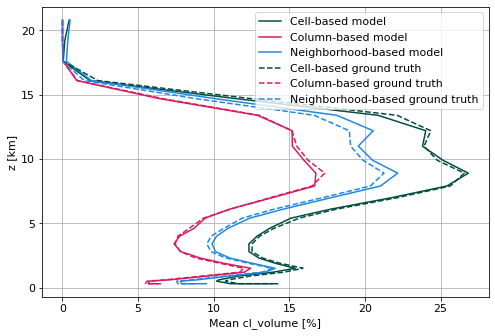

In [29]:
fig = plt.figure(figsize=(8,16/3))

ax = fig.add_subplot(111, xlabel='Mean cl_volume [%]', ylabel='z [km]')

ax.plot(np.array(pred_mean_cell_clc_qubicc), zg_mean_qubicc, color=green)
ax.plot(np.array(pred_mean_column_clc_qubicc), zg_mean_qubicc, color=red)
ax.plot(np.array(pred_mean_region_clc_qubicc), zg_mean_qubicc, color=blue)

ax.plot(np.array(data_mean_cell_clc_qubicc), zg_mean_qubicc, '--',color=green)
ax.plot(np.array(data_mean_column_clc_qubicc), zg_mean_qubicc, '--',color=red)
ax.plot(np.array(data_mean_region_clc_qubicc), zg_mean_qubicc, '--',color=blue)

ax.grid(b=True)
ax.legend(['Cell-based model', 'Column-based model', 'Neighborhood-based model',
           'Cell-based ground truth', 'Column-based ground truth', 'Neighborhood-based ground truth'],loc=1)

plt.savefig('figures/r2b5_qubicc_data_clc_means.pdf')

QUBICC cloud cover models on NARVAL data

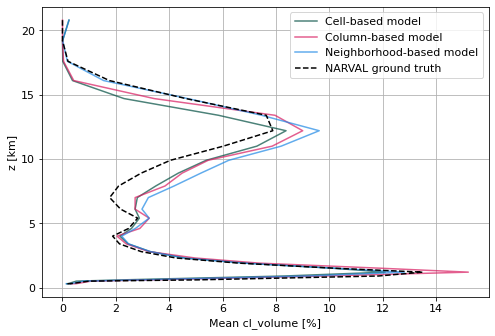

In [32]:
fig = plt.figure(figsize=(8,16/3))

ax = fig.add_subplot(111, xlabel='Mean cl_volume [%]', ylabel='z [km]')

ax.plot(np.array(pred_mean_cell_clc_narval), zg_mean_qubicc, color=green, alpha=.7)
ax.plot(np.array(pred_mean_column_clc_narval), zg_mean_qubicc, color=red, alpha=.7)
ax.plot(np.array(pred_mean_region_clc_narval), zg_mean_qubicc, color=blue, alpha=.7)

ax.plot(np.array(data_mean_cell_clc_narval), zg_mean_qubicc, 'k--')
ax.grid(b=True)

ax.legend(['Cell-based model', 'Column-based model', 'Neighborhood-based model', 
           'NARVAL ground truth'])

plt.savefig('figures/r2b5_narval_data_clc_means.pdf')

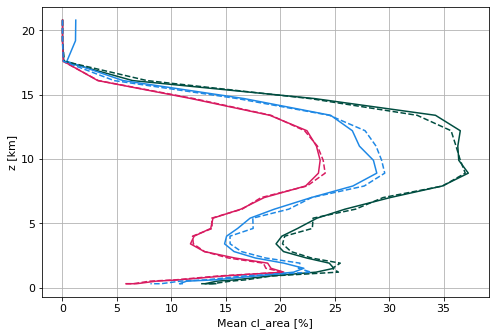

In [34]:
fig = plt.figure(figsize=(8,16/3))

# ax = fig.add_subplot(111, title='QUBICC cloud area models on QUBICC training data',
#                      xlabel='Mean Cloud Area', ylabel='Vertical layer')
ax = fig.add_subplot(111, xlabel='Mean cl_area [%]', ylabel='z [km]')

ax.plot(np.array(pred_mean_cell_cl_area_qubicc), zg_mean_qubicc, color=green)
ax.plot(np.array(pred_mean_column_cl_area_qubicc), zg_mean_qubicc, color=red)
ax.plot(np.array(pred_mean_region_cl_area_qubicc), zg_mean_qubicc, color=blue)

ax.plot(np.array(data_mean_cell_cl_area_qubicc), zg_mean_qubicc, '--', color=green)
ax.plot(np.array(data_mean_column_cl_area_qubicc), zg_mean_qubicc, '--', color=red)
ax.plot(np.array(data_mean_region_cl_area_qubicc), zg_mean_qubicc, '--', color=blue)

ax.grid(b=True)
# ax.legend(['Cell-based Model', 'Column-based Model', 'Region-based Model',
#            'Cell-based Ground Truth', 'Column-based Ground Truth', 'Region-based Ground Truth'])
# plt.gca().invert_yaxis()

plt.savefig('figures/r2b5_qubicc_data_cl_area_means.pdf')

QUBICC cloud area models on NARVAL data

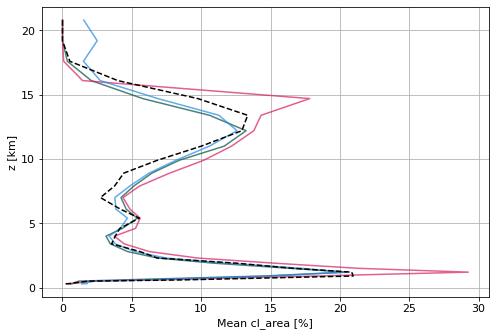

In [35]:
fig = plt.figure(figsize=(8,16/3))

# ax = fig.add_subplot(111, title='QUBICC cloud area models on NARVAL data',
#                      xlabel='Mean Cloud Area', ylabel='Vertical layer')
ax = fig.add_subplot(111, xlabel='Mean cl_area [%]', ylabel='z [km]')

ax.plot(np.array(pred_mean_cell_cl_area_narval), zg_mean_qubicc, color=green, alpha=.7)
ax.plot(np.array(pred_mean_column_cl_area_narval), zg_mean_qubicc, color=red, alpha=.7)
ax.plot(np.array(pred_mean_region_cl_area_narval), zg_mean_qubicc, color=blue, alpha=.7)

# ax.plot(np.array(data_mean_cell_cl_area_narval)*19/25, a, 'g--')
ax.plot(np.array(data_mean_column_cl_area_narval), zg_mean_qubicc, 'k--')
# ax.plot(np.array(data_mean_region_cl_area_narval)*19/25, a, 'b--')
ax.grid(b=True)
# ax.legend(['Cell-based Model','Region-based Model', 'Column-based Model', 
#            'Cell-based Ground Truth', 'Region-based Ground Truth', 'Column-based Ground Truth'])
# plt.gca().invert_yaxis()

plt.savefig('figures/r2b5_narval_data_cl_area_means.pdf')

**R2 plots**

QUBICC cloud cover models on QUBICC training data

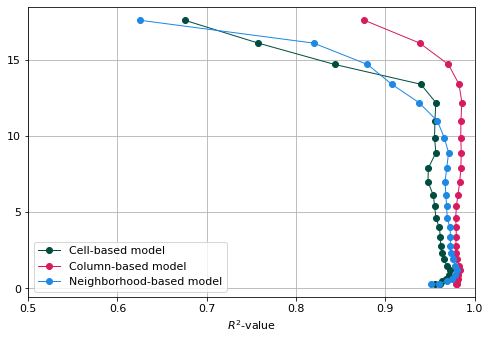

In [37]:
fig = plt.figure(figsize=(8,16/3))

# ax = fig.add_subplot(111, title='QUBICC cloud cover models on QUBICC training data',
#                      xlabel='R2 coefficient of determination (Best: 1)', ylabel='Vertical layer',
#                      xlim=(0.5,1))
ax = fig.add_subplot(111, xlabel='$R^2$-value', xlim=(0.5,1), yticks=[0,5,10,15])

ax.plot(np.array(r2_profile_cell_clc_qubicc)[2:], zg_mean_qubicc[2:], 'o-', color=green, linewidth=1)
ax.plot(np.array(r2_profile_column_clc_qubicc)[2:], zg_mean_qubicc[2:], 'o-', color=red, linewidth=1)
ax.plot(np.array(r2_profile_region_clc_qubicc)[2:], zg_mean_qubicc[2:], 'o-', color=blue, linewidth=1)
ax.grid(b=True)
ax.legend(['Cell-based model','Column-based model','Neighborhood-based model'])
# ax.legend(['Region-based model', 'Region-based with rh model'])
# plt.gca().invert_yaxis()

plt.savefig('figures/r2b5_qubicc_data_clc_r2.pdf')

QUBICC cloud volume models on NARVAL data

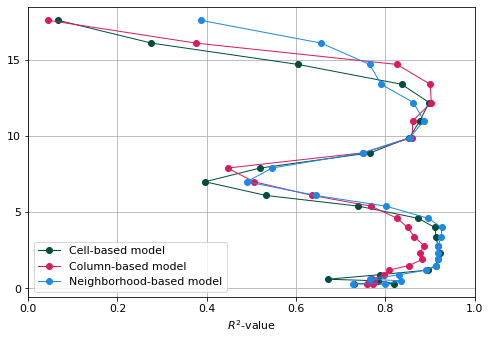

In [41]:
fig = plt.figure(figsize=(8,16/3))

# ax = fig.add_subplot(111, title='QUBICC cloud cover models on NARVAL data', xlim=(0,1),
#                      xlabel='$R^2$-value', ylabel='Vertical layer')
ax = fig.add_subplot(111, xlim=(0,1), xlabel='$R^2$-value', yticks=[0,5,10,15])

ax.plot(np.array(r2_profile_cell_clc_narval)[2:], zg_mean_qubicc[2:], 'o-', color=green, linewidth=1)
ax.plot(np.array(r2_profile_column_clc_narval)[2:], zg_mean_qubicc[2:], 'o-', color=red, linewidth=1)
ax.plot(np.array(r2_profile_region_clc_narval)[2:], zg_mean_qubicc[2:], 'o-', color=blue, linewidth=1)
ax.grid(b=True) 
ax.legend(['Cell-based model', 'Column-based model', 'Neighborhood-based model'])

plt.savefig('figures/r2b5_narval_data_clc_r2.pdf')

QUBICC cloud area models on QUBICC training data

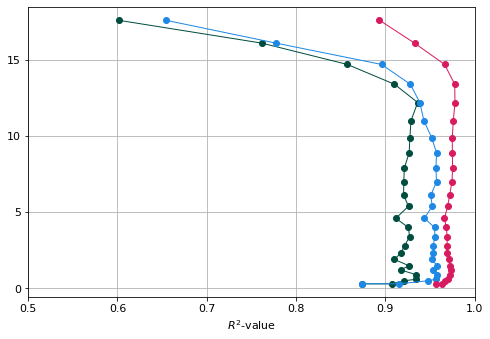

In [42]:
fig = plt.figure(figsize=(8,16/3))

# ax = fig.add_subplot(111, title='QUBICC cloud area models on QUBICC training data', 
#                      xlabel='$R^2$-value', 
#                      xlim=(0.5,1), ylabel='Vertical layer')
ax = fig.add_subplot(111, xlabel='$R^2$-value', xlim=(0.5,1), yticks=[0,5,10,15])

ax.plot(np.array(r2_profile_cell_cl_area_qubicc)[2:], zg_mean_qubicc[2:], 'o-', color=green, linewidth=1)
ax.plot(np.array(r2_profile_region_cl_area_qubicc)[2:], zg_mean_qubicc[2:], 'o-', color=blue, linewidth=1)
ax.plot(np.array(r2_profile_column_cl_area_qubicc)[2:], zg_mean_qubicc[2:], 'o-', color=red, linewidth=1)
ax.grid(b=True)
# ax.legend(['Cell-based model','Region-based model', 'Column-based model'])
# plt.gca().invert_yaxis()

plt.savefig('figures/r2b5_qubicc_data_cl_area_r2.pdf')

QUBICC cloud area models on NARVAL data

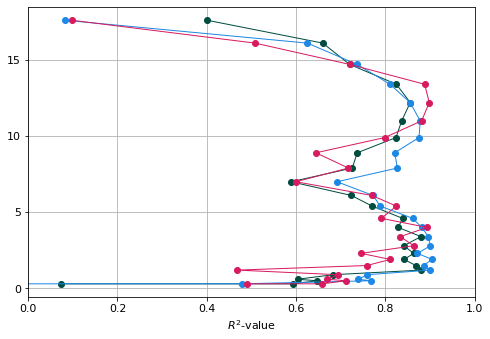

In [54]:
fig = plt.figure(figsize=(8,16/3))

# ax = fig.add_subplot(111, title='QUBICC cloud area models on NARVAL data', xlim=(0,1),
#                      xlabel='R2 coefficient of determination (Best: 1)', ylabel='Vertical layer')
ax = fig.add_subplot(111, xlim=(0,1), xlabel='$R^2$-value', yticks=[0,5,10,15])

ax.plot(np.array(r2_profile_cell_cl_area_narval)[2:], zg_mean_qubicc[2:], 'o-', color=green, linewidth=1)
ax.plot(np.array(r2_profile_region_cl_area_narval)[2:], zg_mean_qubicc[2:], 'o-', color=blue, linewidth=1)
ax.plot(np.array(r2_profile_column_cl_area_narval)[2:], zg_mean_qubicc[2:], 'o-', color=red, linewidth=1)
ax.grid(b=True)
# ax.legend(['Cell-based Model','Region-based Model', 'Column-based Model'])
# plt.gca().invert_yaxis()

plt.savefig('figures/r2b5_narval_data_cl_area_r2.pdf')

### QUBICC models on NARVAL data -- Largest relative error

In [17]:
def comp_rel_error(pred, clc=True):
    if clc:
        return (np.array(pred) - np.array(data_mean_cell_clc_narval))/np.array(data_mean_cell_clc_narval)
    else:
        return (np.array(pred) - np.array(data_mean_column_cl_area_narval))/np.array(data_mean_column_cl_area_narval)

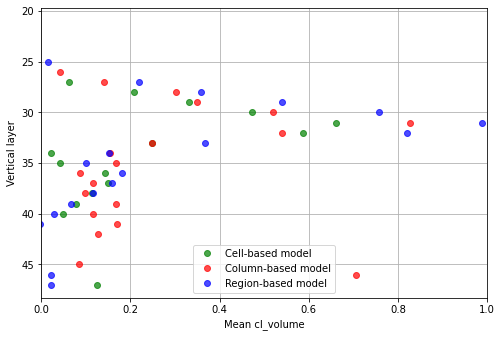

In [18]:
fig = plt.figure(figsize=(8,16/3))

ax = fig.add_subplot(111, xlabel='Mean cl_volume', ylabel='Vertical layer', xlim=[0,1])

ax.plot(comp_rel_error(pred_mean_cell_clc_narval), a, 'go', alpha=.7)
ax.plot(comp_rel_error(pred_mean_column_clc_narval), a, 'ro', alpha=.7)
ax.plot(comp_rel_error(pred_mean_region_clc_narval), a, 'bo', alpha=.7)

# ax.plot(np.array(data_mean_column_clc_narval), a, 'r--')
# ax.plot(np.array(data_mean_region_clc_narval), a, 'b--')
ax.grid(b=True)

ax.legend(['Cell-based model', 'Column-based model', 'Region-based model',
           'NARVAL ground truth'])
plt.gca().invert_yaxis()

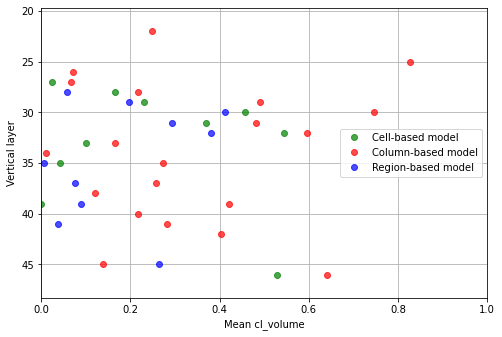

In [19]:
fig = plt.figure(figsize=(8,16/3))

ax = fig.add_subplot(111, xlabel='Mean cl_volume', ylabel='Vertical layer', xlim=[0,1])

ax.plot(comp_rel_error(pred_mean_cell_cl_area_narval, clc=False), a, 'go', alpha=.7)
ax.plot(comp_rel_error(pred_mean_column_cl_area_narval, clc=False), a, 'ro', alpha=.7)
ax.plot(comp_rel_error(pred_mean_region_cl_area_narval, clc=False), a, 'bo', alpha=.7)

# ax.plot(np.array(data_mean_column_clc_narval), a, 'r--')
# ax.plot(np.array(data_mean_region_clc_narval), a, 'b--')
ax.grid(b=True)

ax.legend(['Cell-based model', 'Column-based model', 'Region-based model',
           'NARVAL ground truth'])
plt.gca().invert_yaxis()

In [21]:
print((r2_profile_cell_clc_narval)[11])
print((r2_profile_column_clc_narval)[11])
print((r2_profile_region_clc_narval)[11])

0.39593560594297716
0.505691513
0.4895354959394955


#### Absolute error

In [36]:
#Absolute error
np.abs(np.array(pred_mean_column_clc_narval) - np.array(data_mean_cell_clc_narval))[32-21]

0.9544029307706363